In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
SEED = 1

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("Device", device)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

Device cuda


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      transforms.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [4]:
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:01<00:00, 99487848.07it/s] 


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [5]:
kwargs = {'batch_size': 128, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

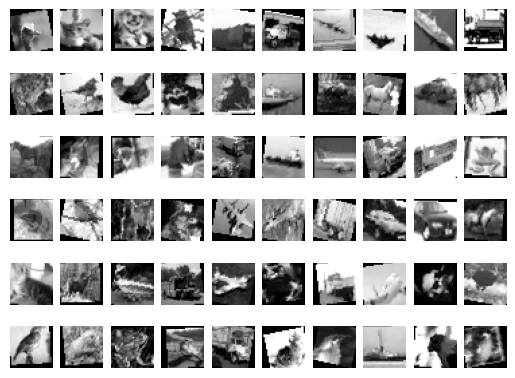

In [6]:
images, labels = next(iter(train_loader))
#print(images[0,1:].numpy().squeeze())


figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index][1:][1:].numpy().squeeze(),cmap="gray")

In [21]:
def calc_activation_shape(dim, ksize=3, stride=1, padding=0):
      odim_i = (dim + (2 * padding) - ksize)
      return (odim_i // stride) + 1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        ln_shape = calc_activation_shape(dim=32, ksize=3,padding=0)
        print("ln shape 1: ",ln_shape)

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.LayerNorm([8, ln_shape, ln_shape]),
            nn.Dropout(0.10)
        ) # output_size = 32

        ln_shape = calc_activation_shape(ln_shape, ksize=3,padding=0)
        print("ln shape 2: ",ln_shape)

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.LayerNorm([16, ln_shape, ln_shape]),
            nn.Dropout(0.10)
        ) # output_size = 30

        ln_shape = calc_activation_shape(ln_shape, ksize=2, stride=2 ,padding=0)
        print("ln shape 3: ",ln_shape)

        #Adding AntMan and MaxPool
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 30
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 15

        ln_shape = calc_activation_shape(ln_shape, ksize=3,padding=1)
        print("ln shape 4: ",ln_shape)

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([16, ln_shape, ln_shape]),
            nn.Dropout(0.10)
        ) # output_size = 15

        ln_shape = calc_activation_shape(ln_shape, ksize=3,padding=0)
        print("ln shape 5: ",ln_shape)

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.LayerNorm([16, ln_shape, ln_shape]),
            nn.Dropout(0.10)
        ) # output_size = 13

        ln_shape = calc_activation_shape(ln_shape, ksize=3,padding=1)
        print("ln shape 6: ",ln_shape)

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([32, ln_shape, ln_shape]),
            nn.Dropout(0.10)
        ) # output_size = 13

        ln_shape = calc_activation_shape(ln_shape, ksize=2, stride=2, padding=0)
        print("ln shape 7: ",ln_shape)

        #Adding AntMan and MaxPool
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 13
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 6

        ln_shape = calc_activation_shape(ln_shape, ksize=3,padding=1)
        print("ln shape 8: ",ln_shape)

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([32, ln_shape, ln_shape]),
            nn.Dropout(0.10)
        ) # output_size = 6

        ln_shape = calc_activation_shape(ln_shape, ksize=3,padding=0)
        print("ln shape 9: ",ln_shape)

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.LayerNorm([32, ln_shape, ln_shape]),
            nn.Dropout(0.10)
        ) # output_size = 4

        ln_shape = calc_activation_shape(ln_shape, ksize=3,padding=1)
        print("ln shape 10: ",ln_shape)

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([64, ln_shape, ln_shape]),
            nn.Dropout(0.10)
        ) # output_size = 4

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool2(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.gap(x)
        x = self.convblock11(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [23]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
ln shape 1:  30
ln shape 2:  28
ln shape 3:  14
ln shape 4:  14
ln shape 5:  12
ln shape 6:  12
ln shape 7:  6
ln shape 8:  6
ln shape 9:  4
ln shape 10:  4
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]             216
              ReLU-2            [-1, 8, 30, 30]               0
         LayerNorm-3            [-1, 8, 30, 30]          14,400
           Dropout-4            [-1, 8, 30, 30]               0
            Conv2d-5           [-1, 16, 28, 28]           1,152
              ReLU-6           [-1, 16, 28, 28]               0
         LayerNorm-7           [-1, 16, 28, 28]          25,088
           Dropout-8           [-1, 16, 28, 28]               0
            Conv2d-9            [-1, 8, 28, 28]             128
        MaxPool2d-10            [-1, 8, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           1,152
     

In [24]:
#Function for calculating correct predictions
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train() #Setting model in train mode
  pbar = tqdm(train_loader) #Loading bar

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad() #To prevent gradient accumulation

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  return (100*correct/processed,train_loss/len(train_loader))

#Model testing
def test(model, device, test_loader, criterion):
    model.eval() #Put model in test mode

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (100. * correct / len(test_loader.dataset),test_loss)

In [25]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) #For adjusting weights post error calculation
criterion = F.nll_loss

In [26]:
epochs = 20
train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(1,epochs+1):
    print(f'Epoch {epoch}')
    train_accuracy, train_loss = train(model, device, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    test_accuracy, test_loss = test(model, device, test_loader, criterion)
    test_acc.append(test_accuracy)
    test_losses.append(test_loss)

Epoch 1


Train: Loss=1.5460 Batch_id=390 Accuracy=32.70: 100%|██████████| 391/391 [00:34<00:00, 11.34it/s]


Test set: Average loss: 1.5188, Accuracy: 4416/10000 (44.16%)

Epoch 2


Train: Loss=1.6190 Batch_id=390 Accuracy=43.38: 100%|██████████| 391/391 [00:35<00:00, 11.13it/s]


Test set: Average loss: 1.4528, Accuracy: 4671/10000 (46.71%)

Epoch 3


Train: Loss=1.4071 Batch_id=390 Accuracy=48.87: 100%|██████████| 391/391 [00:35<00:00, 10.89it/s]


Test set: Average loss: 1.2815, Accuracy: 5357/10000 (53.57%)

Epoch 4


Train: Loss=1.2776 Batch_id=390 Accuracy=51.95: 100%|██████████| 391/391 [00:36<00:00, 10.82it/s]


Test set: Average loss: 1.1823, Accuracy: 5684/10000 (56.84%)

Epoch 5


Train: Loss=1.3220 Batch_id=390 Accuracy=54.29: 100%|██████████| 391/391 [00:36<00:00, 10.76it/s]


Test set: Average loss: 1.1829, Accuracy: 5754/10000 (57.54%)

Epoch 6


Train: Loss=1.2154 Batch_id=390 Accuracy=55.74: 100%|██████████| 391/391 [00:35<00:00, 10.95it/s]


Test set: Average loss: 1.1257, Accuracy: 5954/10000 (59.54%)

Epoch 7


Train: Loss=1.0473 Batch_id=390 Accuracy=57.49: 100%|██████████| 391/391 [00:35<00:00, 10.95it/s]


Test set: Average loss: 1.0487, Accuracy: 6254/10000 (62.54%)

Epoch 8


Train: Loss=0.9240 Batch_id=390 Accuracy=58.66: 100%|██████████| 391/391 [00:35<00:00, 11.07it/s]


Test set: Average loss: 1.0123, Accuracy: 6437/10000 (64.37%)

Epoch 9


Train: Loss=1.1600 Batch_id=390 Accuracy=59.69: 100%|██████████| 391/391 [00:35<00:00, 10.99it/s]


Test set: Average loss: 0.9915, Accuracy: 6510/10000 (65.10%)

Epoch 10


Train: Loss=1.0784 Batch_id=390 Accuracy=60.11: 100%|██████████| 391/391 [00:35<00:00, 10.94it/s]


Test set: Average loss: 1.0169, Accuracy: 6402/10000 (64.02%)

Epoch 11


Train: Loss=1.1368 Batch_id=390 Accuracy=61.59: 100%|██████████| 391/391 [00:36<00:00, 10.70it/s]


Test set: Average loss: 0.9598, Accuracy: 6649/10000 (66.49%)

Epoch 12


Train: Loss=0.9504 Batch_id=390 Accuracy=62.07: 100%|██████████| 391/391 [00:34<00:00, 11.22it/s]


Test set: Average loss: 0.9256, Accuracy: 6674/10000 (66.74%)

Epoch 13


Train: Loss=1.1081 Batch_id=390 Accuracy=62.57: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]


Test set: Average loss: 0.9351, Accuracy: 6716/10000 (67.16%)

Epoch 14


Train: Loss=0.9660 Batch_id=390 Accuracy=63.28: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


Test set: Average loss: 0.9205, Accuracy: 6762/10000 (67.62%)

Epoch 15


Train: Loss=1.1154 Batch_id=390 Accuracy=64.16: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


Test set: Average loss: 0.8812, Accuracy: 6916/10000 (69.16%)

Epoch 16


Train: Loss=1.1398 Batch_id=390 Accuracy=64.22: 100%|██████████| 391/391 [00:34<00:00, 11.22it/s]


Test set: Average loss: 0.8978, Accuracy: 6887/10000 (68.87%)

Epoch 17


Train: Loss=0.9286 Batch_id=390 Accuracy=64.99: 100%|██████████| 391/391 [00:35<00:00, 10.88it/s]


Test set: Average loss: 0.8744, Accuracy: 6926/10000 (69.26%)

Epoch 18


Train: Loss=1.0755 Batch_id=390 Accuracy=64.98: 100%|██████████| 391/391 [00:34<00:00, 11.23it/s]


Test set: Average loss: 0.8698, Accuracy: 6971/10000 (69.71%)

Epoch 19


Train: Loss=0.9311 Batch_id=390 Accuracy=65.67: 100%|██████████| 391/391 [00:35<00:00, 10.99it/s]


Test set: Average loss: 0.8359, Accuracy: 7069/10000 (70.69%)

Epoch 20


Train: Loss=0.9808 Batch_id=390 Accuracy=66.08: 100%|██████████| 391/391 [00:35<00:00, 11.03it/s]


Test set: Average loss: 0.8185, Accuracy: 7173/10000 (71.73%)

